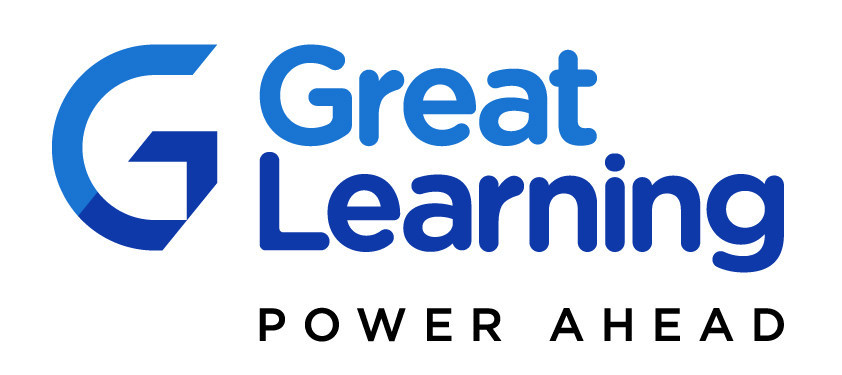

# **Prompt Engineering SQL Coder 2 for Text to Query Generation**

In [ ]:
# Installation for GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --upgrade --no-cache-dir --verbose

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 179.5 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 2.8 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Running command Getting requirements to build wheel
  Getting requirements to build wheel ... done
  Running command pip subprocess to install backend dependencies
  Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 46.0 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 26.6 MB/s eta 0:00:00
    Creating /tmp/pip-build-env-y_ckz8qb/normal/local/bin
    changing

## **Hugging Face Hub**

In [ ]:
# For downloading the models from HF Hub
!pip install huggingface_hub

## **Importing the SQL Coder 2 model**

In [ ]:
# Import the hf_hub_download function from the Hugging Face Hub library
from huggingface_hub import hf_hub_download

# Import the Llama class from the llama_cpp library
from llama_cpp import Llama

In [ ]:
sqlcoder2_model_name_or_path = "TheBloke/sqlcoder2-GGUF"
sqlcoder2_model_basename = "sqlcoder2.Q4_K_M.gguf" # the model is in gguf format
#  sqlcoder2.Q5_K_S.gguf

In [ ]:
sqlcoder2_model_path = hf_hub_download(
    repo_id=sqlcoder2_model_name_or_path,
    filename=sqlcoder2_model_basename
)

In [ ]:
sqlcoder2_llm = Llama(
    model_path=sqlcoder2_model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096, # Context window
)

llama_model_loader: loaded meta data with 19 key-value pairs and 485 tensors from /root/.cache/huggingface/hub/models--TheBloke--sqlcoder2-GGUF/snapshots/bb29b37e3365a1b181d64fd6b0a3a3db83000509/sqlcoder2.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = starcoder
llama_model_loader: - kv   1:                               general.name str              = StarCoder
llama_model_loader: - kv   2:                   starcoder.context_length u32              = 8192
llama_model_loader: - kv   3:                 starcoder.embedding_length u32              = 6144
llama_model_loader: - kv   4:              starcoder.feed_forward_length u32              = 24576
llama_model_loader: - kv   5:                      starcoder.block_count u32              = 40
llama_model_loader: - kv   6:             starcoder.attention.head_count u32

In [ ]:
import pandas as pd
import sqlite3
from datetime import datetime, timedelta
import random

In [ ]:
# # TO DELETE TABLES IN DATABASE

# conn = sqlite3.connect('sample_database.db')
# cursor = conn.cursor()

# # Assuming tables are already created, we skip table creation for brevity

# # Clear existing data
# cursor.execute('DELETE FROM products')
# cursor.execute('DELETE FROM customers')
# cursor.execute('DELETE FROM salespeople')
# cursor.execute('DELETE FROM sales')
# cursor.execute('DELETE FROM product_suppliers')

In [ ]:
# Function to subtract months from a date
def subtract_months(dt, months):
    month = dt.month - 1 - months  # Months are 1-12 in datetime
    year = dt.year + month // 12
    month = month % 12 + 1
    day = min(dt.day, [31, 29 if year % 4 == 0 and not year % 400 == 0 else 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][month - 1])
    return datetime(year, month, day)

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('sample_database.db')
cursor = conn.cursor()

# Create tables as per the provided schema
cursor.execute('''
CREATE TABLE products (
  product_id INTEGER PRIMARY KEY,
  name VARCHAR(50),
  price DECIMAL(10,2),
  quantity INTEGER
);''')

cursor.execute('''
CREATE TABLE customers (
  customer_id INTEGER PRIMARY KEY,
  name VARCHAR(50),
  address VARCHAR(100)
);''')

cursor.execute('''
CREATE TABLE salespeople (
  salesperson_id INTEGER PRIMARY KEY,
  name VARCHAR(50),
  region VARCHAR(50)
);''')

cursor.execute('''
CREATE TABLE sales (
  sale_id INTEGER PRIMARY KEY,
  product_id INTEGER,
  customer_id INTEGER,
  salesperson_id INTEGER,
  sale_date DATE,
  quantity INTEGER
);''')

cursor.execute('''
CREATE TABLE product_suppliers (
  supplier_id INTEGER PRIMARY KEY,
  product_id INTEGER,
  supply_price DECIMAL(10,2)
);''')


# Helper function to generate random dates
def random_date(start, end):
    return (start + timedelta(
        seconds=random.randint(0, int((end - start).total_seconds())),
    )).date()

# Generate sample data
product_names = ['Laptop', 'Smartphone', 'Tablet', 'Monitor', 'Keyboard', 'Mouse', 'Webcam', 'Headset', 'Printer', 'Scanner']
customer_names = ['John Doe', 'Jane Smith', 'Alice Johnson', 'Bob Brown', 'Sally Green', 'Rick White', 'Charlie Black', 'Dana Grey', 'Evan Blue', 'Fiona Purple']
salesperson_names = ['Sam Red', 'Olivia Orange', 'Liam Yellow', 'Emma Green', 'Noah Blue', 'Ava Indigo', 'Isabella Violet', 'Sophia Silver', 'Mason Gold', 'Mia Bronze']
regions = ['North', 'South', 'East', 'West', 'Central']

# Define the date range for the last 6 months
current_date = datetime.now()
start_date = subtract_months(current_date, 6)  # Start date 6 months before today
end_date = current_date  # Today's date

products_data = [(i+1, f'{name} {i}', round(random.uniform(50, 1500), 2), random.randint(5, 100)) for i, name in enumerate(product_names*3)]
customers_data = [(i+1, f'{name} {i}', f'{random.randint(100, 999)} {random.choice(["Elm St.", "Maple Ave.", "Pine St.", "Oak Rd.", "Cedar Ln."])}') for i, name in enumerate(customer_names*3)]
salespeople_data = [(i+1, f'{name} {i}', random.choice(regions)) for i, name in enumerate(salesperson_names*3)]
sales_data = [(i+1, random.randint(1, 30), random.randint(1, 30), random.randint(1, 30), random_date(start_date, end_date).isoformat(), random.randint(1, 10)) for i in range(30)]
product_suppliers_data = [(i+1, random.randint(1, 30), round(random.uniform(30, 1400), 2)) for i in range(30)]

# Insert data into each table
cursor.executemany('INSERT INTO products VALUES (?,?,?,?)', products_data)
cursor.executemany('INSERT INTO customers VALUES (?,?,?)', customers_data)
cursor.executemany('INSERT INTO salespeople VALUES (?,?,?)', salespeople_data)
cursor.executemany('INSERT INTO sales VALUES (?,?,?,?,?,?)', sales_data)
cursor.executemany('INSERT INTO product_suppliers VALUES (?,?,?)', product_suppliers_data)

conn.commit()  # Commit the transaction

# Close the database connection
conn.close()


In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('sample_database.db')
cursor = conn.cursor()

# Define a list of table names
tables = ['products', 'customers', 'salespeople', 'sales', 'product_suppliers']

# Fetch and print the first few rows from each table
for table in tables:
    print(f"Data from {table}:")
    cursor.execute(f'SELECT * FROM {table} LIMIT 5')  # Adjust the limit as needed
    # Fetch all rows from the cursor
    rows = cursor.fetchall()
    # Print rows
    for row in rows:
        print(row)
    print()  # Add a newline for better readability between tables

# Close the database connection
conn.close()


Data from products:
(1, 'Laptop 0', 1200.02, 71)
(2, 'Smartphone 1', 575.86, 73)
(3, 'Tablet 2', 1198.15, 74)
(4, 'Monitor 3', 1452.56, 63)
(5, 'Keyboard 4', 161.84, 60)

Data from customers:
(1, 'John Doe 0', '491 Maple Ave.')
(2, 'Jane Smith 1', '916 Cedar Ln.')
(3, 'Alice Johnson 2', '493 Elm St.')
(4, 'Bob Brown 3', '572 Pine St.')
(5, 'Sally Green 4', '394 Cedar Ln.')

Data from salespeople:
(1, 'Sam Red 0', 'Central')
(2, 'Olivia Orange 1', 'North')
(3, 'Liam Yellow 2', 'North')
(4, 'Emma Green 3', 'South')
(5, 'Noah Blue 4', 'East')

Data from sales:
(1, 13, 15, 2, '2023-12-27', 8)
(2, 13, 25, 17, '2023-10-06', 10)
(3, 22, 18, 10, '2023-11-18', 10)
(4, 11, 27, 1, '2024-02-26', 5)
(5, 18, 22, 3, '2023-11-12', 3)

Data from product_suppliers:
(1, 15, 542.75)
(2, 29, 512.47)
(3, 7, 924.34)
(4, 4, 1012.15)
(5, 15, 1020.8)



In [ ]:
prompt  = """### Task
Generate a SQLite query to answer [QUESTION]{question}[/QUESTION]

### Instructions
- If you cannot answer the question with the available database schema, return 'I do not know'
- Remember that revenue is price multiplied by quantity
- Remember that cost is supply_price multiplied by quantity

### Database Schema
This query will run on a database whose schema is represented in this string:
CREATE TABLE products (
  product_id INTEGER PRIMARY KEY, -- Unique ID for each product
  name VARCHAR(50), -- Name of the product
  price DECIMAL(10,2), -- Price of each unit of the product
  quantity INTEGER  -- Current quantity in stock
);

CREATE TABLE customers (
   customer_id INTEGER PRIMARY KEY, -- Unique ID for each customer
   name VARCHAR(50), -- Name of the customer
   address VARCHAR(100) -- Mailing address of the customer
);

CREATE TABLE salespeople (
  salesperson_id INTEGER PRIMARY KEY, -- Unique ID for each salesperson
  name VARCHAR(50), -- Name of the salesperson
  region VARCHAR(50) -- Geographic sales region
);

CREATE TABLE sales (
  sale_id INTEGER PRIMARY KEY, -- Unique ID for each sale
  product_id INTEGER, -- ID of product sold
  customer_id INTEGER,  -- ID of customer who made purchase
  salesperson_id INTEGER, -- ID of salesperson who made the sale
  sale_date DATE, -- Date the sale occurred
  quantity INTEGER -- Quantity of product sold
);

CREATE TABLE product_suppliers (
  supplier_id INTEGER PRIMARY KEY, -- Unique ID for each supplier
  product_id INTEGER, -- Product ID supplied
  supply_price DECIMAL(10,2) -- Unit price charged by supplier
);

-- sales.product_id can be joined with products.product_id
-- sales.customer_id can be joined with customers.customer_id
-- sales.salesperson_id can be joined with salespeople.salesperson_id
-- product_suppliers.product_id can be joined with products.product_id

### Answer
Given the database schema, here is the SQL query that answers [QUESTION]{question}[/QUESTION]
[SQL]
"""

In [ ]:
def generate_query_response(updated_prompt):

  try:

      # Use the model (lcpp_llm) to generate a response based on the few-shot prompt
      response = sqlcoder2_llm(
          prompt=updated_prompt,
          max_tokens=500,
          temperature=0,
          top_p=0.95,
          repeat_penalty=1.2,
          top_k=50,
          stop=['INST'], # Dynamic stopping when such token is detected.
          echo=False # do not return the prompt
      )
      # Extract the model's prediction from the response

      prediction = response["choices"][0]["text"]

      return prediction

  except ValueError as e:
        # Handle any ValueErrors that may occur during the process and continue with the next row

      print(e)

**Question 1**

In [ ]:
question = "What was our revenue by product in the North region last month?"

In [ ]:
updated_prompt = prompt.format(question=question)

In [ ]:
result_1 = generate_query_response(updated_prompt)


llama_print_timings:        load time =    1260.39 ms
llama_print_timings:      sample time =     104.60 ms /   113 runs   (    0.93 ms per token,  1080.26 tokens per second)
llama_print_timings: prompt eval time =    1441.89 ms /   519 tokens (    2.78 ms per token,   359.94 tokens per second)
llama_print_timings:        eval time =    7247.26 ms /   112 runs   (   64.71 ms per token,    15.45 tokens per second)
llama_print_timings:       total time =    9363.73 ms /   631 tokens


In [ ]:
print(result_1)

SELECT products.name AS Product_Name, SUM(sales.quantity::DECIMAL * sales.sale_date::DECIMAL) AS total_revenue FROM sales JOIN salespeople ON sales.salesperson_id = salespeople.salesperson_id JOIN customers ON sales.customer_id = customers.customer_id JOIN products ON sales.product_id = products.product_id WHERE salespeople.region = 'North' AND sales.sale_date >= (CURRENT_DATE - interval '1 month') GROUP BY products.name;


In [ ]:
result_1

"SELECT products.name AS Product_Name, SUM(sales.quantity::DECIMAL * sales.sale_date::DECIMAL) AS total_revenue FROM sales JOIN salespeople ON sales.salesperson_id = salespeople.salesperson_id JOIN customers ON sales.customer_id = customers.customer_id JOIN products ON sales.product_id = products.product_id WHERE salespeople.region = 'North' AND sales.sale_date >= (CURRENT_DATE - interval '1 month') GROUP BY products.name;"

**Question 2**

In [ ]:
question = "What is the sales conversion rate of each salesperson region wise assuming no entry is null?"

In [ ]:
updated_prompt = prompt.format(question=question)

In [ ]:
result_2 = generate_query_response(updated_prompt)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1258.54 ms
llama_print_timings:      sample time =      83.67 ms /    95 runs   (    0.88 ms per token,  1135.47 tokens per second)
llama_print_timings: prompt eval time =    1321.86 ms /   511 tokens (    2.59 ms per token,   386.58 tokens per second)
llama_print_timings:        eval time =    6924.93 ms /    94 runs   (   73.67 ms per token,    13.57 tokens per second)
llama_print_timings:       total time =    8705.93 ms /   605 tokens


In [ ]:
print(result_2)

SELECT salespeople.region AS salesperson_region, SUM(sales.quantity::FLOAT / NULLIF(product_suppliers.supply_price::FLOAT, 0)) AS sales_to_supply_ratio FROM sales JOIN product_suppliers ON sales.product_id = product_suppliers.product_id JOIN salespeople ON sales.salesperson_id = salespeople.salesperson_id GROUP BY salespeople.region;


In [ ]:
result_2

'SELECT salespeople.region AS salesperson_region, SUM(sales.quantity::FLOAT / NULLIF(product_suppliers.supply_price::FLOAT, 0)) AS sales_to_supply_ratio FROM sales JOIN product_suppliers ON sales.product_id = product_suppliers.product_id JOIN salespeople ON sales.salesperson_id = salespeople.salesperson_id GROUP BY salespeople.region;'

Clear GPU RAM

In [ ]:
import torch
del sqlcoder2_llm
torch.cuda.empty_cache()

### **Postgresql to Sqlite Conversion**

In [ ]:
llama_model_name_or_path = "TheBloke/CodeLlama-13B-Instruct-GGUF"
llama_model_basename = "codellama-13b-instruct.Q5_K_M.gguf" # the model is in gguf format
#  sqlcoder2.Q5_K_S.gguf

In [ ]:
llama_model_path = hf_hub_download(
    repo_id=llama_model_name_or_path,
    filename=llama_model_basename
)

In [ ]:
llama_llm = Llama(
    model_path=llama_model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096, # Context window
)

llama_model_loader: loaded meta data with 20 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--CodeLlama-13B-Instruct-GGUF/snapshots/82f1dd9567b9b20b7e8f8aa9ecf3d2f121e5d415/codellama-13b-instruct.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = codellama_codellama-13b-instruct-hf
llama_model_loader: - kv   2:                       llama.context_length u32              = 16384
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   

In [ ]:
def convert_to_sqlite(query):

  try:
      system_message = """
    Act as sql generator and follow below instructions
    - You will be given postgresql query.
    - You need to convert it to sqlite3 query and give output.
    - Output Only the sqlite query .
    - Take time but give accurate results.

    Important :
    - COMPULSORY TO GIVE ONLY QUERY IN OUTPUT . DO not add any text like : Here is your converted SQLite query: , before or after , only query .
    - Verify your answer if the query is converted properly to sqlite and no text except for query should be before and after . if these condition not satisfied , regenrate to meet these conditions .

    """

      # Combine user_prompt and system_message to create the prompt
      prompt = f"[INST]<<SYS>>{system_message}\n{query}<</SYS>>[/INST]"

      # Use the model (lcpp_llm) to generate a response based on the few-shot prompt
      response = llama_llm(
          prompt=prompt,
          max_tokens=500,
          temperature=0,
          top_p=0.95,
          repeat_penalty=1.2,
          top_k=50,
          stop=['INST'], # Dynamic stopping when such token is detected.
          echo=False # do not return the prompt
      )
      # Extract the model's prediction from the response

      prediction = response["choices"][0]["text"]

      return prediction

  except ValueError as e:
        # Handle any ValueErrors that may occur during the process and continue with the next row

      print(e)



In [ ]:
def sql_query_to_pd(sql_query_string: str, db_name: str ='default.db') -> pd.DataFrame:
    '''Execute an SQL query and return the results as a pandas dataframe

    Args:
        sql_query_string (str): SQL query string to execute
        db_name (str, optional): Name of the SQLITE Database to execute the query in.
                                 Defaults to 'default.db'.

    Returns:
        pd.DataFrame: Results of the SQL query in a pandas dataframe
    '''
    # Step 1: Connect to the SQL DB
    con = sqlite3.connect(db_name)

    # Step 2: Execute the SQL query
    cursor = con.execute(sql_query_string)

    # Step 3: Fetch the data and column names
    result_data = cursor.fetchall()
    cols = [description[0] for description in cursor.description]

    # Step 4: Close the connection
    con.close()

    # Step 5: Return as a dataframe
    return pd.DataFrame(result_data, columns=cols)

In [ ]:
result_1

"SELECT products.name AS Product_Name, SUM(sales.quantity::DECIMAL * sales.sale_date::DECIMAL) AS total_revenue FROM sales JOIN salespeople ON sales.salesperson_id = salespeople.salesperson_id JOIN customers ON sales.customer_id = customers.customer_id JOIN products ON sales.product_id = products.product_id WHERE salespeople.region = 'North' AND sales.sale_date >= (CURRENT_DATE - interval '1 month') GROUP BY products.name;"

In [ ]:
sqlite_query_1 = convert_to_sqlite(result_1)


llama_print_timings:        load time =     848.94 ms
llama_print_timings:      sample time =      59.79 ms /   111 runs   (    0.54 ms per token,  1856.37 tokens per second)
llama_print_timings: prompt eval time =     848.33 ms /   288 tokens (    2.95 ms per token,   339.49 tokens per second)
llama_print_timings:        eval time =    7330.72 ms /   110 runs   (   66.64 ms per token,    15.01 tokens per second)
llama_print_timings:       total time =    8553.87 ms /   398 tokens


In [ ]:
sqlite_query_1

"  SELECT products.name AS Product_Name, SUM(sales.quantity * sales.sale_date) AS total_revenue FROM sales JOIN salespeople ON sales.salesperson_id = salespeople.salesperson_id JOIN customers ON sales.customer_id = customers.customer_id JOIN products ON sales.product_id = products.product_id WHERE salespeople.region = 'North' AND sales.sale_date >= (DATE() - 1) GROUP BY products.name;"

In [ ]:
sql_query_to_pd(sqlite_query_1,'sample_database.db')

,Product_Name,total_revenue
0,Headset 17,6069
1,Printer 28,8092
2,Scanner 19,12144
3,Tablet 12,36414


In [ ]:
result_2

'SELECT salespeople.region AS salesperson_region, SUM(sales.quantity::FLOAT / NULLIF(product_suppliers.supply_price::FLOAT, 0)) AS sales_to_supply_ratio FROM sales JOIN product_suppliers ON sales.product_id = product_suppliers.product_id JOIN salespeople ON sales.salesperson_id = salespeople.salesperson_id GROUP BY salespeople.region;'

In [ ]:
sqlite_query_2 = convert_to_sqlite(result_2)

Llama.generate: prefix-match hit

llama_print_timings:        load time =     848.94 ms
llama_print_timings:      sample time =      52.53 ms /    95 runs   (    0.55 ms per token,  1808.59 tokens per second)
llama_print_timings: prompt eval time =     480.88 ms /   109 tokens (    4.41 ms per token,   226.67 tokens per second)
llama_print_timings:        eval time =    6201.57 ms /    94 runs   (   65.97 ms per token,    15.16 tokens per second)
llama_print_timings:       total time =    7044.66 ms /   203 tokens


In [ ]:
sqlite_query_2

'  SELECT salespeople.region AS salesperson_region, SUM(sales.quantity / NULLIF(product_suppliers.supply_price, 0)) AS sales_to_supply_ratio FROM sales JOIN product_suppliers ON sales.product_id = product_suppliers.product_id JOIN salespeople ON sales.salesperson_id = salespeople.salesperson_id GROUP BY salespeople.region;'

In [ ]:
sql_query_to_pd(sqlite_query_2,'sample_database.db')

,salesperson_region,sales_to_supply_ratio
0,Central,0.028508
1,East,0.073539
2,North,0.051449
3,South,0.040571
4,West,0.070634


In [ ]:
import torch
del llama_llm
torch.cuda.empty_cache()